# Experiment 1 - Two Class Supervised & Unsupervised

## Details
Observe the effect of selective PN to iKC connectivity on the network's representational power.

### Model Info
**Random Sparse**: Neurons are connected randomly with probabilty $p = 0.05$ across the network. Network parameters:
\begin{align}
& g_{PN,iKC} \in \mathcal{N}(0.5, 0.1)\\
& g_{iKC,eKC} \in \mathcal{N}(1.25, 0.5)\\
& \tau_{PN,iKC} = \tau_{iKC,eKC} = 5\\
& p_{PN,iKC} = p_{iKC,eKC} = 0.05\\
\end{align}

All neurons are current-based LIFs with exponential post-synaptic decay. The following parameters are of note:
\begin{align}
\tau_m &= 10\:\mathrm{ms}\\
v_{thresh} &= -50\:\mathrm{mV}
\end{align}

The iKC and eKC populations form sWTA circuits by lateral inhibition:

Neuron population sizes are as follows:

\begin{align}
& N_{PN} = \frac{d_{input}}{4}\\
& N_{iKC} = 10 \times N_{PN}\\
& N_{eKC} = 500
\end{align}

where $d_{input}$ is the dimensionality of (flattened) image tensors.

Each input class contains 20 samples, and each sample is shown $N_{round}$ times to the model, for a total sample size of $N_{sample} = N_{round} \times N_{class}$. Unless otherwise stated, $N_{class} = 2$ and $N_{round} = 4$. The number of samples per class is kept balanced.

### Spike Coding
Prior to spike coding, images are downscaled by a factor of 4. The images are binarized by setting the top 5% of active pixels to 1, and the rest to 0. This also goes to create sparser input patterns. Images are encoded into spike times as instantaneous snapshots plus a small amount of jitter drawn from $\mathcal{U}(-\epsilon, \epsilon)$. During training, samples drawn are shown to the model within 50ms windows. eKC neuron activity, as a response to an input pattern, is the firing rate within these windows.

To analyse eKC population activity, we calculate:
- Population distance tables (cosine and manhattan distance)
- Changes in mean pre-synaptic eKC weights over time
- Per interval per eKC neuron firing rate and input class correlation
- Per interval mean (eKC) firing rate and input class correlation

## TODO
- [x] Each run there seems to a sample that causes a large number of iKC (and thus eKC) neurons to fire. Find what images cause such strong responses
- [ ] Add functionality for supervision
- [ ] Add analysis for class distances

In [1]:
# Add my library
import sys
import os

sys.path.append(os.getcwd() + "/lib")

In [2]:
import numpy as np
import scipy
import h5py as h5
import matplotlib.pyplot as plt
import seaborn as sns

from two_class import get_inputs, run # Experiment script

from lib.util import retrieve_results
from lib.analysis import calculate_activity
from pyNN.utility.plotting import Figure, Panel
from pyNN.random import RandomDistribution

sns.set_style("whitegrid")

Inputs: (2, 80, 729)
Image Dimensions: 27 x 27
Image Vector: 729
Sparsity Ratio per-class: [0.92160494 0.93374486]


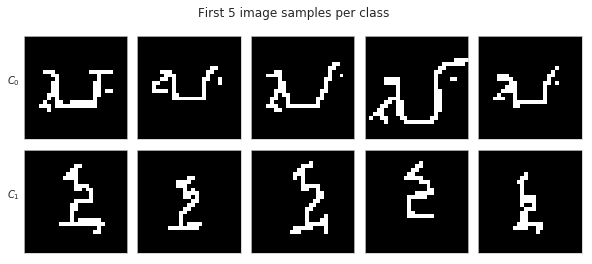

In [3]:
# Fetch inputs and preview examples
N_CLASS = 2
DOWNSCALE = 4
N_ROUNDS = 4

inputs = get_inputs(N_CLASS, DOWNSCALE)
inputs = np.tile(inputs, (N_ROUNDS,1))
print("Inputs:", inputs.shape)

samples = inputs[:,:5]
w = h = int(np.sqrt(samples.shape[-1]))

print(f"Image Dimensions: {w} x {h}")
print(f"Image Vector: {samples.shape[-1]}")
print(f"Sparsity Ratio per-class: {1-inputs.mean(axis=-1).mean(axis=-1)}")

fig, rows = plt.subplots(N_CLASS, 5, figsize=(10,4))
for i,axes in enumerate(rows):
    for j,(ax,img) in enumerate(zip(axes,samples[i])):
        if j == 0:
            ax.set_ylabel(fr"$C_{i}$".format(i), rotation=0, labelpad=10.0)
        ax.imshow(img.reshape(w,h), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

fig.suptitle("First 5 image samples per class")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [4]:
# Neuron parameters
neuron_params = {
    "tau_m": 10.0,
    "i_offset": 0.1
}

projection_params = {
    "PN_iKC": {
        "weight": RandomDistribution('normal', (0.8, 0.05)),
        "delay": 2.0
    },
    "iKC_eKC": {
        "weight": RandomDistribution('normal', (2.0, 0.5)),
        "delay": 5.0
    }
}

In [5]:
# Additional parameters
VERSION = 0
WEIGHT_LOG_FREQ = 20
SPIKE_JITTER = 2 # epsilon
RUNS = 4

In [6]:
sim_params = run(      
    inputs,
    runs=RUNS,
    spike_jitter=SPIKE_JITTER,
    weight_log_freq=WEIGHT_LOG_FREQ,
    version=VERSION,
    neuron_params=neuron_params,
    proj_params=projection_params
)

Setting up
 -- steps: 4100
 -- n_PN: 729
 -- n_iKC: 7290
 -- n_eKC: 500
Initializing weight logger...
Running simulation..

[ ########################################################################### ] 100%    

Done
Saving results...
Saving simulation params...


In [7]:
# Fetch data
data = retrieve_results("two_class", version=VERSION)
sim_params = sim_params if sim_params else np.load(f"results/two_class_{VERSION}/params.npz")
weights = np.load(f"results/two_class_{VERSION}/weights.npy", allow_pickle=True)

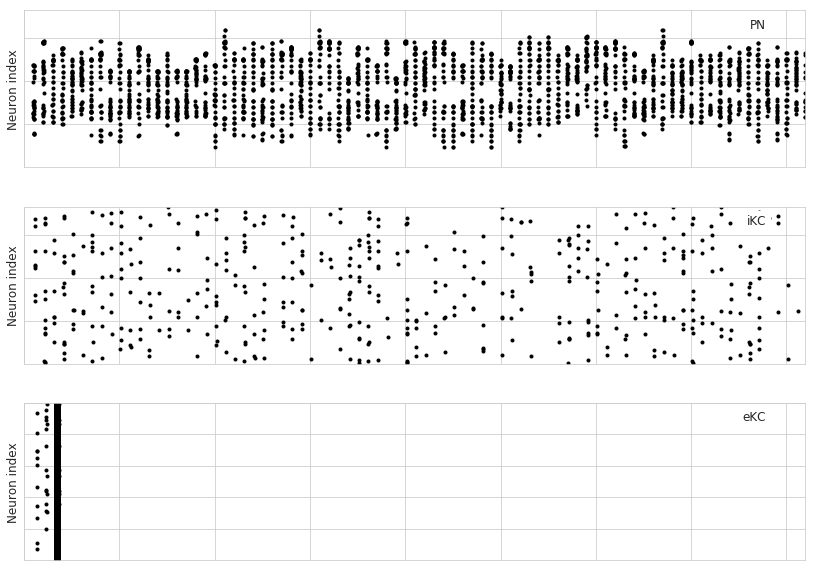

In [8]:
# Plot spikes
plot_run = 0

Figure(
    Panel(data['PN'].segments[plot_run].spiketrains, data_labels=["PN"]),
    Panel(data['iKC'].segments[plot_run].spiketrains, data_labels=["iKC"]),
    Panel(data['eKC'].segments[plot_run].spiketrains, data_labels=["eKC"]),
    settings={ "font.size": 12 }
)

plt.gcf().set_size_inches(14,10)
plt.show()

## eKC activity

In [46]:
eKC_activity = []
for i in range(RUNS):
    activity = calculate_activity(
        data['eKC'].segments[i].spiketrains, 
        sim_params['intervals'], 
        sim_params['t_snapshot']
    )
    
    eKC_activity.append(activity)

eKC_activity = np.array(eKC_activity)

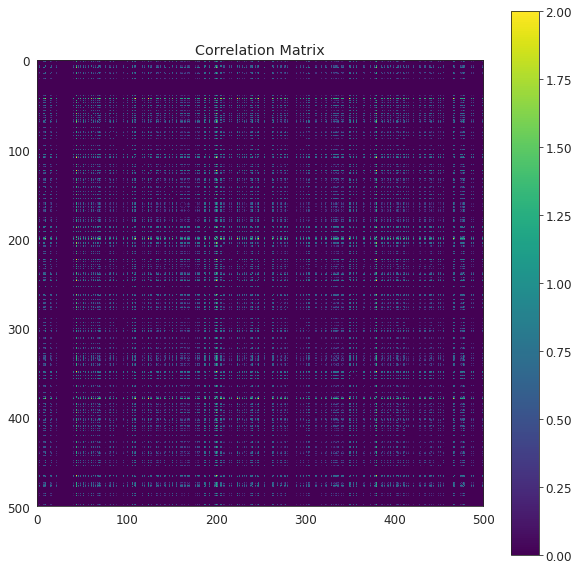

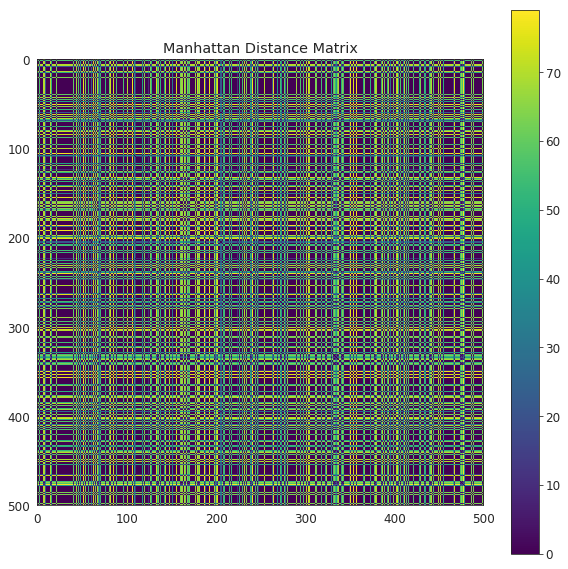

In [47]:
def distance_matrix(activity, metric):
    return np.nan_to_num(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(activity, metric=metric)))

# Average across runs
mean_eKC_activity = eKC_activity.mean(axis=0)

# Plot distance tables
sns.set_style("white")
plt.gcf().set_size_inches(10,10)

plt.imshow(distance_matrix(mean_eKC_activity, 'correlation'), cmap='viridis')
plt.title("Correlation Matrix")
plt.colorbar()
plt.show()

plt.gcf().set_size_inches(10,10)

plt.imshow(distance_matrix(mean_eKC_activity, 'cityblock'), cmap='viridis')
plt.title("Manhattan Distance Matrix")
plt.colorbar()
plt.show()

## Weights Analysis

In [48]:
# Changes in weight
weight_trajectories = []
for traj in weights:
    traj = np.array(traj)
    weight_trajectories.append(traj.mean(axis=1))

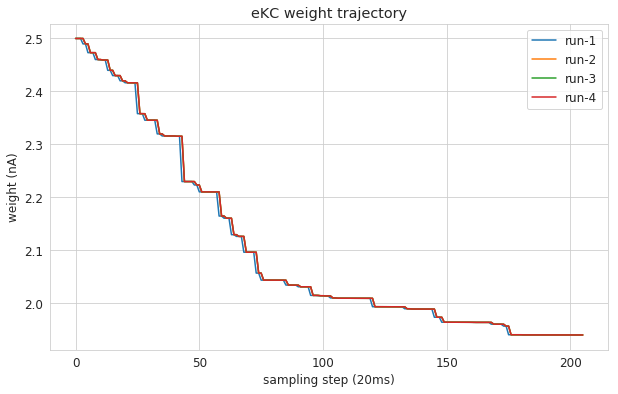

In [49]:
sns.set_style("whitegrid")
for i,traj in enumerate(weight_trajectories):
    plt.plot(traj, label=f"run-{i+1}")

plt.legend()
plt.gcf().set_size_inches(10,6)
plt.title("eKC weight trajectory")
plt.xlabel(f"sampling step ({WEIGHT_LOG_FREQ}ms)")
plt.ylabel("weight (nA)")
plt.show()